# Load and smooth the topography data of Earth2014 

### Database

1. Earth2012 - Spherical harmonic models of Earth's topography and potential
       
   Earth2012 is the first release of Earth's topography models (topography, bedrock, rock-equivalent topography) in spherical harmonic coefficients to harmonic degree 2160. [Doc](http://ddfe.curtin.edu.au/gravitymodels/Earth2012/earth2012_website.pdf) and [Download](http://ddfe.curtin.edu.au/models/Earth2012/).

2. Earth2014 - Arc‐min shape, topography, bedrock and ice‐sheet models

   Earth2014 is available as gridded data and degree‐10,800 spherical harmonics. [Doc](http://ddfe.curtin.edu.au/models/Earth2014/Hirt_Rexer2015_Earth2014.pdf) and [Download](http://ddfe.curtin.edu.au/models/Earth2014/). The Earth2014 suite of global relief and topography models is based on four input data sets:
   - SRTM30_PLUS (Becker et al. 2009) v9 (Dec 2013) bathymetry and topography model,
   - SRTM V4.1 topography (Jarvis et al. 2008) over all land areas between ?60° latitude,
   - Bedmap2 (Fretwell et al. 2013) bedrock, bathymetry and ice thickness data over Antarctica,
   - Greenland Bedrock Topography (GBT v3, Bamber et al. 2013, Bamber 2014, pers. comm.).


In [1]:
import numpy as np
import os
import pyshtools as pysh
pysh.utils.figstyle(rel_width=0.75)
%config InlineBackend.figure_format = 'retina'  # if you are not using a retina display, comment this line

from osgeo import gdal
from osgeo import osr

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 1. Load and plot  

Data:Earth2014.TBI2014.5min. [Download](http://ddfe.curtin.edu.au/models/Earth2014/data_5min/topo_grids/)

In [2]:
dir_db   = '../data/earth2014/data_5min/topo_grids'
fname_db = 'Earth2014.TBI2014.5min.geod.bin' 
fname_save  = 'Earth2014.TBI2014.5min' 

fname_topo = os.path.join(dir_db,fname_db)
print(fname_topo)

../data/earth2014/data_5min/topo_grids/Earth2014.TBI2014.5min.geod.bin


In [3]:
# This scirpt shows how to access the data grids of earth2014 model
# Source code: access_Earth2014_grids5min.m (Christian Hirt, Moritz Rexer)

# grid definitions
res_deg = 5/60 # 5min data
extent_global = [-180, 180, -90, 90]
minlon,maxlon,minlat,maxlat = extent_global
lats = np.arange((minlat+res_deg/2),(maxlat-res_deg/4),res_deg)
lons = np.arange((minlon+res_deg/2),(maxlon-res_deg/4),res_deg)
nlat = len(lats)
nlon = len(lons)
order_db = nlat
minlon1,maxlon1,minlat1,maxlat1 = (lons.min(),lons.max(),lats.min(),lats.max())
extent_earth2014 = [minlon1,maxlon1,minlat1,maxlat1]

# read data
data_topo = np.fromfile(fname_topo, dtype='>i2').reshape((nlat, nlon))
data_topo = data_topo.astype(np.int16) # data = data.astype('<i2')
data_topo = np.flipud(data_topo)

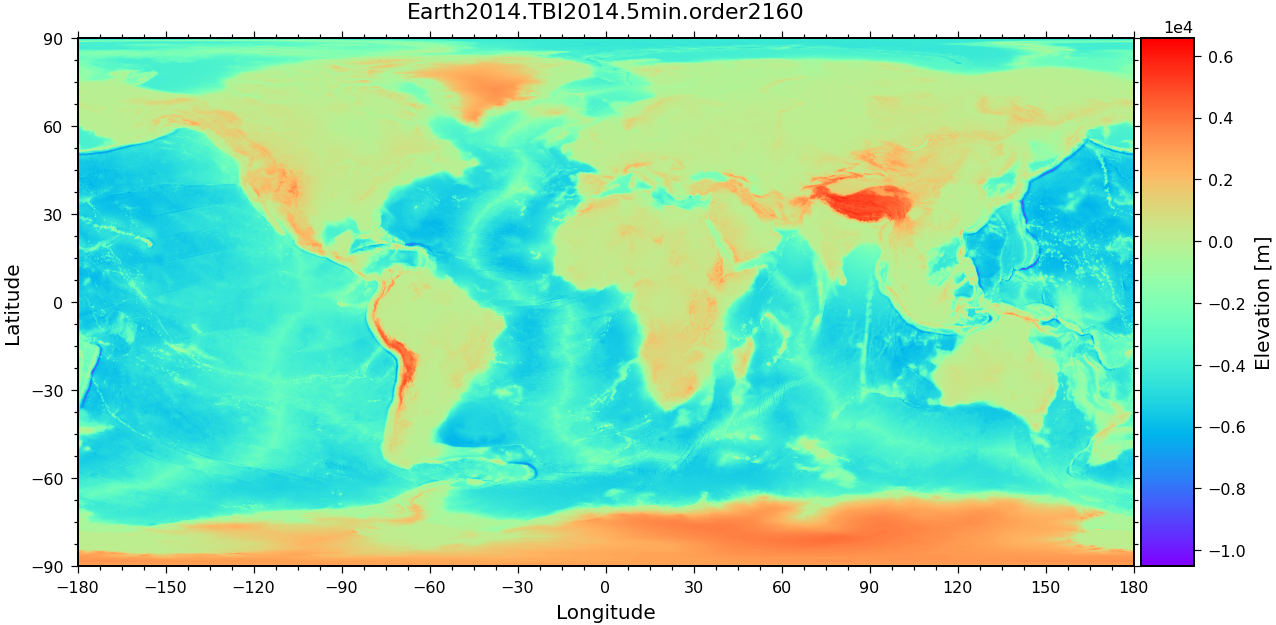

In [4]:
order_img  = order_db 
data_img   = data_topo.copy()
extent_img = extent_earth2014 #(-180, 180, -90, 90)
extent_fig = extent_global
cmap = cm.rainbow 
xticks = np.arange(-180,210,30)
yticks = np.arange(-90,120,30)
dpi    = 100
save_mode = True
fname_fig = fname_save + '.order'+ str(order_img)


fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(data_img, extent=extent_img,cmap=cmap)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks, xticks=xticks)
ax.minorticks_on()
ax.set_title(fname_fig)
ax.axis(extent_fig)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label('Elevation [m]')

if save_mode == True:
    plt.savefig((fname_fig+'.png'),dpi=dpi)

## 2. Use SHtools to get the spherical harmonics coeffients (SHCs) 

pyshtools: Spherical Harmonic Tools. [Github](https://github.com/SHTOOLS/SHTOOLS) and [Doc](https://shtools.oca.eu/shtools/public/index.html)

Cite: Wieczorek, M. A., & Meschede, M. (2018). Shtools: Tools for working with spherical harmonics. Geochemistry, Geophysics, Geosystems, 19(8), 2574-2592.

In [5]:
topo = pysh.SHGrid.from_array(data_topo)
coeffs = pysh.expand.SHExpandDH(topo.data, sampling=2)

In [6]:
# power_per_l = pysh.spectralanalysis.spectrum(coeffs)
# degrees = np.arange(coeffs.shape[1])

# fig, ax = plt.subplots(1, 1)
# ax.plot(degrees, power_per_l)
# #ax.plot(logx=True) 
# ax.set(yscale='log', xscale='log', xlabel='Spherical harmonic degree', ylabel='Power')
# ax.grid()

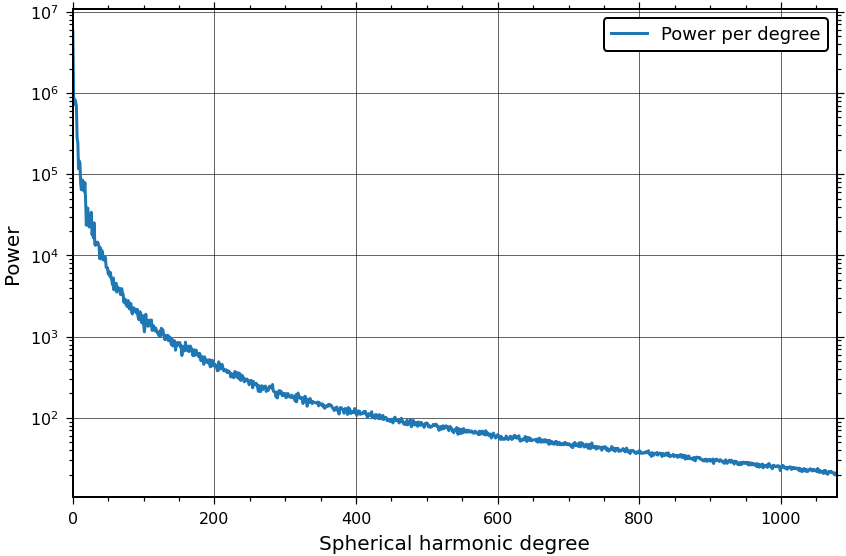

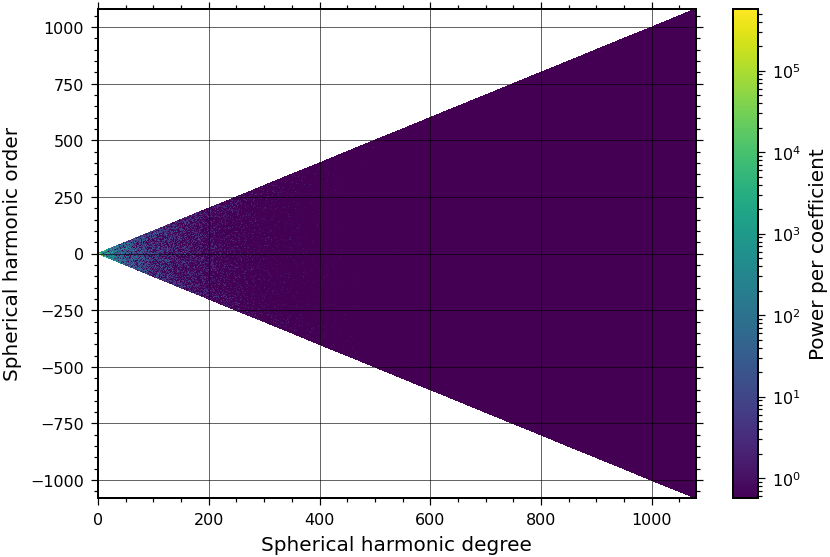

In [7]:
coeffsn = pysh.SHCoeffs.from_array(coeffs)
fig, ax = coeffsn.plot_spectrum(show=False)
fig, ax = coeffsn.plot_spectrum2d(vrange=(1.e-7,0.1),
                              show=False)

## 3. Smooth (filter) the topography by processing the SHCs 

In [8]:
order_s = order_db # degree/order of soure data
order_t = 20       # degree/order of target data
lmax = int(order_t+1)

In [9]:
coeffs_f = coeffs.copy()
coeffs_f[:, lmax:, :] = 0.
topo_f = pysh.expand.MakeGridDH(coeffs_f, sampling=2)

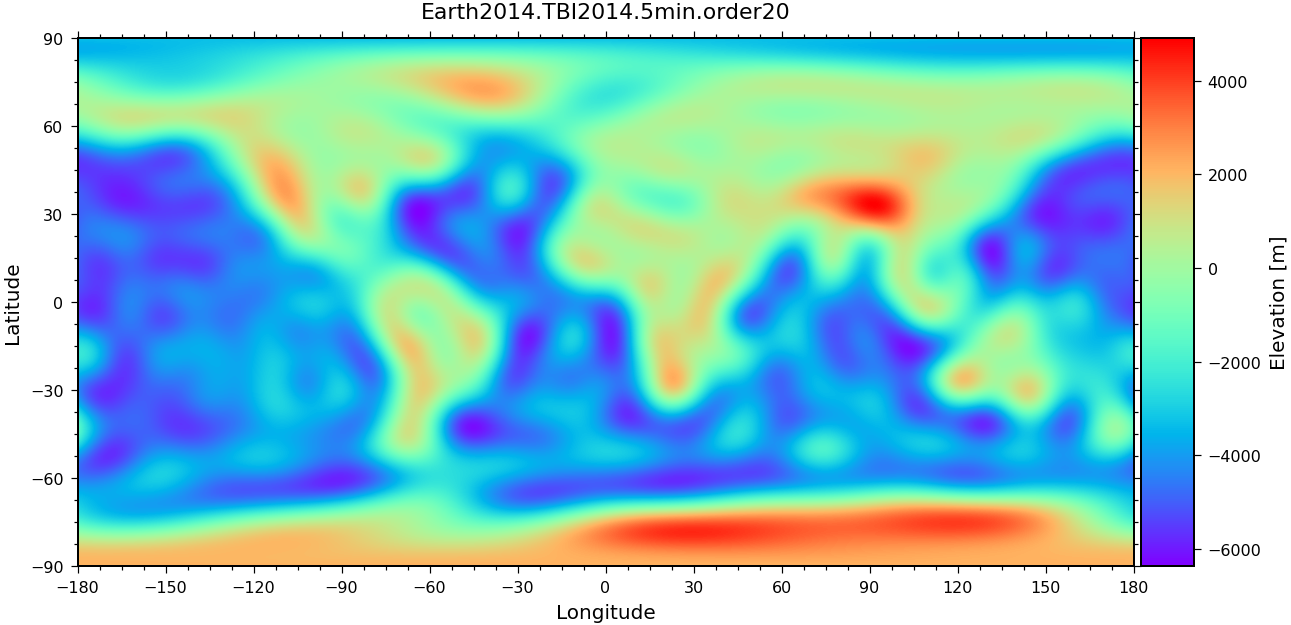

In [10]:
order_img  = order_t 
data_img   = topo_f.copy()
extent_img = extent_earth2014 #(-180, 180, -90, 90)
extent_fig = extent_global
cmap = cm.rainbow 
xticks = np.arange(-180,210,30)
yticks = np.arange(-90,120,30)
dpi    = 100
save_mode = True
fname_fig = fname_save + '.order'+ str(order_img)


fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.imshow(data_img, extent=extent_img,cmap=cmap)
ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks, xticks=xticks)
ax.minorticks_on()
ax.set_title(fname_fig)
ax.axis(extent_fig)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label('Elevation [m]')

if save_mode == True:
    plt.savefig((fname_fig+'.png'),dpi=dpi)

## 4. Save data as geotiff file

In [11]:
import sys 
sys.path.append("..") 
from qixiang import functions as fnqx

In [ ]:
data =  topo_f.copy()
fname_data = fname_save + '.order'+ str(order_s)+ '.tif'
latRange = [minlat1,maxlat1]
lonRange = [minlon1,maxlon1]
dtype = gdal.GDT_Float32

fnqx.array2geotiff_yx(fname_data, data, latRange, lonRange, dtype)